# How to see the flows of bikes in the Bike Share Toronto Service

**Does bike share go round trip or one way?**

>The purpose of this notebook is to analyse the flow of bikes. Are bikes returned to its initial location? Or are there flows of bike from one region to another?

The sum of all the travels for each station for one year are too noisy, so 
* Data can be split between weekend days or not
* Stations can be grouped by proximity in order to define regions
* Data can be summarized by period of time ( Day, Week , Month, Year)
* Focus on 2018, that should be enough representative

Graph representation :
* A node is a station or a region
* A edge is the sum of all travel between 2 nodes during a period of time
* For each node we consider the balance between outgoing and incoming flows
* To simplify : a travel from one station to the same station is not taken in account. (balance is zero)
* To simplify : the inverse edges are grouped as follow, (10 travels from 1 to 2 and 12 travels from 2 to 1, gives  -2 travels from 1 to 2) (5 travels from 1 to 2 and 4 travels from 2 to 1, gives  +1 travels from 1 to 2) 

The plan

* [Get the stations information](#station_info)
* [Load the data](#load_data)
* [Clustering of the stations in 20 regions](#clustering_region)


In [ ]:
# import librairies
import numpy as np
import pandas as pd
import time 
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16,13]

In [ ]:
root2017="/kaggle/input/toronto-bikeshare-data/bikeshare-ridership-2017/"
root2018="/kaggle/input/toronto-bikeshare-data/bikeshare2018/"
files2017=[root2017+"2017 Data/Bikeshare Ridership (2017 Q1).csv",
root2017+"2017 Data/Bikeshare Ridership (2017 Q2).csv",
root2017+"2017 Data/Bikeshare Ridership (2017 Q3).csv",
root2017+"2017 Data/Bikeshare Ridership (2017 Q4).csv"]
files2018=[root2018+"bikeshare2018/Bike Share Toronto Ridership_Q1 2018.csv",
root2018+"bikeshare2018/Bike Share Toronto Ridership_Q2 2018.csv",
root2018+"bikeshare2018/Bike Share Toronto Ridership_Q3 2018.csv",
root2018+"bikeshare2018/Bike Share Toronto Ridership_Q4 2018.csv"]

<a id="station_info"></a>
# Get the stations information (gps coordinates) from https://tor.publicbikesystem.net

In [ ]:
# get the stations information from https://tor.publicbikesystem.net
req = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
stations = json.loads(req.content)['data']['stations']
stations = pd.DataFrame(stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

stations.head()

# Load the data
> <span>&#171;</span>This can be a little bit long, because of the date parsing of the column 'trip_start_time'<span>&#187;</span>

In [ ]:
# load the data

first=True

for f in files2018:
    start_time = time.time()
    data = pd.read_csv(f,parse_dates = ['trip_start_time'],dayfirst=True)
    if first:
        df=data
        first=False
    else:
        df=df.append(data,sort=True)
    print("file {} -- {} seconds --".format(f,time.time() - start_time))        
del data , first


## Cleaning and columns mapping

In [ ]:
# Hour of the day
df['hour'] = df['trip_start_time'].dt.hour
# Day of the week
df['dayofweek'] = df['trip_start_time'].dt.dayofweek
# Date
df['date'] = df['trip_start_time'].dt.floor('d')
# 2 stations in the dataset are not in the list of available stations, so map to the closest
df.loc[df['to_station_id']==7068,'to_station_id']=7399
df.loc[df['to_station_id']==7219,'to_station_id']=7148
df.loc[df['from_station_id']==7068,'from_station_id']=7399
df.loc[df['from_station_id']==7219,'from_station_id']=7148

In [ ]:
df.head()

# Clustering of the stations in 20 regions

> <span>&#171;</span>There are 463 stations, so the idea is to group them in order to have 20 regions <br/> this will be easier to see the flow of bikes between these 20 regions <span>&#187;</span>


### KMeans on gps coordinates (nbr_cluster = 20)

In [ ]:
from sklearn.cluster import KMeans
X = stations[['lon', 'lat']].values
n_clusters_ = 20
kmeans = KMeans(n_clusters = n_clusters_, init ='k-means++')
kmeans.fit(X) # Compute k-means clustering.
labels = kmeans.fit_predict(X)

### Map stations with its cluster

In [ ]:
# Coordinates of cluster centers.
centers = kmeans.cluster_centers_ 

# map each station with its region
stations['clusters']=labels
stations.index=stations['station_id']
cluster_map = stations['clusters'].to_dict()
df['from_station_c']=df['from_station_id'].map(cluster_map)
df['to_station_c']=df['to_station_id'].map(cluster_map)

### See the clusters

In [ ]:
import matplotlib.image as mpimg
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
BBox = (-79.4900,-79.2700,43.6100,43.7200)
# map_tor = mpimg.imread('map.png')
fig, ax = plt.subplots()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
    ax.text(centers[k, 0], centers[k, 1], k,fontsize=12)
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

# Plot over a map
<div class="alert alert-block alert-warning">
Question : how can I load the image 'map.png' as input in order to execute this code ?
</div>

To do this, the following line have to be uncomment in the code above :
```
# map_tor = mpimg.imread('map.png')
...
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
```


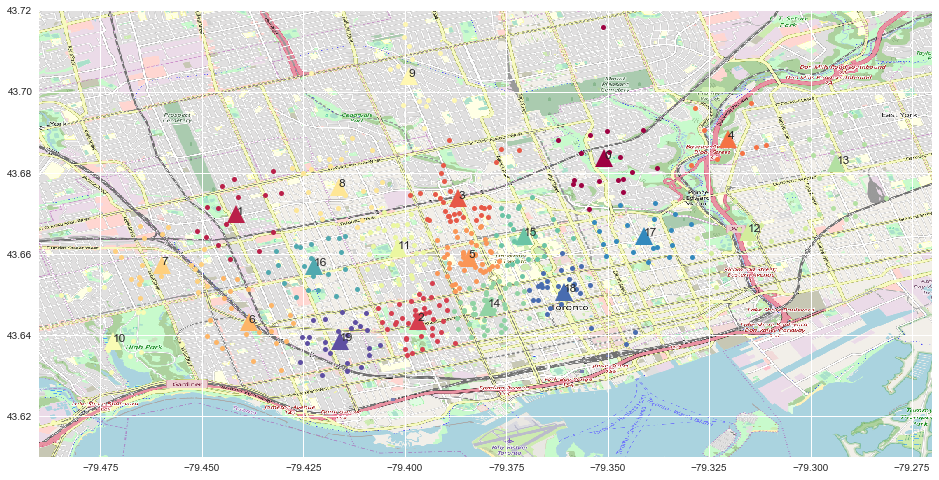

# Count edges

In [ ]:
##############################
# Count edges
##############################


df['region_count']=(df['from_station_c']<df['to_station_c']).astype(int)-(df['from_station_c']>df['to_station_c']).astype(int)
df['region_key'] = df[['from_station_c','to_station_c']].min(axis=1).astype('str') +'_'+ df[['from_station_c','to_station_c']].max(axis=1).astype('str')

df['station_count']=(df['from_station_id']<df['to_station_id']).astype(int)-(df['from_station_id']>df['to_station_id']).astype(int)
df['station_key'] = df[['from_station_id','to_station_id']].min(axis=1).astype('str') +'_'+ df[['from_station_id','to_station_id']].max(axis=1).astype('str')

df.describe(include=['O'])
df.columns




# Flows for the year 2018

In [ ]:
##############################
# Extract flows and create graph
##############################

def getFlows(region=True,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01'),days = [0,1,2,3,4,5,6]):
    # flows
    if region:
        flows = df.loc[(df['from_station_c']!=df['to_station_c'])&(df['dayofweek'].isin(days)) & (df['date']>=start_date) & (df['date']<end_date) ].groupby(['region_key'])['region_count'].sum()
    else:
        flows = df.loc[(df['from_station_id']!=df['to_station_id'])&(df['dayofweek'].isin(days)) & (df['date']>=start_date) & (df['date']<end_date) ].groupby(['station_key'])['station_count'].sum()
    # graph
    G = nx.DiGraph()
    for index, value in flows.items():
        G.add_weighted_edges_from([(int(index.split('_')[0]), int(index.split('_')[1]), value)])
    # degrees of each nodes
    nodes=[]
    degrees=[]
    for e in G:
        nodes.append(e)
        degrees.append(G.in_degree(e, weight='weight')-G.out_degree(e, weight='weight'))
    deg = pd.Series(data=degrees,index=nodes).sort_values()
    return flows,G,deg

f_stations_w, g_stations_w , d_stations_w = getFlows(region=False,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01'),days = [0,1,2,3,4])
f_stations_we, g_stations_we , d_stations_we = getFlows(region=False,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01'),days = [5,6])
f_regions_w, g_regions_w , d_regions_w = getFlows(region=True,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01'),days = [0,1,2,3,4])
f_regions_we, g_regions_we , d_regions_we = getFlows(region=True,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01'),days = [5,6])


# Top 10 stations in negative / positive over the year 2018

In [ ]:
top10 = pd.DataFrame(np.vstack([d_stations_w.iloc[:10].index.values,d_stations_w.iloc[-10:].index.values,d_stations_we.iloc[:10].index.values,d_stations_we.iloc[-10:].index.values]).transpose()
                                     ,columns=["Negative_Week","Positive_Week","Negative_Weekend","Positive_Weekend"])
top10["Negative_Week"] = top10["Negative_Week"].map(stations['name'])
top10["Positive_Week"] = top10["Positive_Week"].map(stations['name'])
top10["Negative_Weekend"] = top10["Negative_Weekend"].map(stations['name'])
top10["Positive_Weekend"] = top10["Positive_Weekend"].map(stations['name'])

top10.head(10)

In [ ]:
############################################################
# Plot the graphs
############################################################
def plot_G_stations(G,degrees,ptitle=""):
    colors=[]
    pos={}
    node_sizes=[]
    max_deg = degrees.abs().max()
    labels={}
    for e in G:
        d=degrees[e]
        node_sizes.append(100 + 500*(abs(d)/max_deg))
        pos[int(e)]=(stations.loc[e,'lon'],stations.loc[e,'lat'])
        labels[int(e)]=(int(d))
        if d==0:
            colors.append('#00aedb')
        elif d < 0:
            colors.append('#f37735')
        else: 
            colors.append('#00b159')
    nx.draw_networkx_nodes(G,pos, node_size=node_sizes,node_color=colors)
    nx.draw_networkx_labels(G, pos,labels= labels, font_size=7)
    plt.title(ptitle)
    plt.show()



def plot_G_regions(G,flows,degrees,ptitle=""):
    colors=[]
    pos={}
    max_deg = degrees.abs().max()
    node_sizes=[]
    labels={}
    for e in G:
        d=degrees[e]
        node_sizes.append(100 + 600*(abs(d)/max_deg))
        pos[int(e)]=(centers[e,0],centers[e,1])
        labels[int(e)]=(int(d))
        if d==0:
            colors.append('#00aedb')
        elif d < 0:
            colors.append('#f37735')
        else: 
            colors.append('#00b159')

    color_cut_pos = flows[flows>0].median()
    color_cut_neg = flows[flows<0].median()

    elargepos = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >color_cut_pos]
    elargeneg = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < color_cut_neg]
    eother = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= color_cut_neg and d['weight'] <= color_cut_pos]

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,node_color=colors,alpha=0.9)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elargepos,edge_color='#00b159', width=4,alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=elargeneg,edge_color='#f37735', width=4,alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=eother,edge_color='#00aedb', width=1,alpha=0.5)

    # labels
    nx.draw_networkx_labels(G, pos, labels= labels,font_size=14)
    plt.title(ptitle)
    plt.show()

## For the year 2018, flows between regions for the weekdays

In [ ]:
plot_G_regions(g_regions_w,f_regions_w,d_regions_w)

## For the year 2018, flows between regions during the weekends

In [ ]:
plot_G_regions(g_regions_we,f_regions_we,d_regions_we)

## For the year 2018, negative/positive stations during the weekdays

In [ ]:
plot_G_stations(g_stations_w,  d_stations_w)

## For the year 2018, negative/positive stations during the weekends

In [ ]:
plot_G_stations(g_stations_we,  d_stations_we)

# Average flows by day

In [ ]:
def getAverageFlowsByDays(region=True,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01')):
    
    f_list=[]
    d_list=[]
    g_list=[]
    # flows
    if region:
        flows = df.loc[(df['from_station_c']!=df['to_station_c'])& (df['date']>=start_date) & (df['date']<end_date) ].groupby(['region_key','date'],as_index=False)['region_count'].sum()
        flows['dayofweek']=flows['date'].dt.dayofweek
        flows = flows.groupby(['region_key','dayofweek'],as_index=False)['region_count'].mean()
    else:
        flows = df.loc[(df['from_station_id']!=df['to_station_id'])& (df['date']>=start_date) & (df['date']<end_date) ].groupby(['station_key','date'],as_index=False)['station_count'].sum()
        flows['dayofweek']=flows['date'].dt.dayofweek
        flows = flows.groupby(['station_key','dayofweek'],as_index=False)['station_count'].mean()
    
    for day in range(0,7):
        f=flows.loc[flows['dayofweek']==day]       
        if region:
            f.index = f['region_key']
            f=f['region_count']
        else:
            f.index = f['station_key']
            f=f['station_count']
        f_list.append(f)
        # graph
        G = nx.DiGraph()
        for index, value in f.items():
            G.add_weighted_edges_from([(int(index.split('_')[0]), int(index.split('_')[1]), value)])
        g_list.append(G)
        # degrees of each nodes
        nodes=[]
        degrees=[]
        for e in G:
            nodes.append(e)
            degrees.append(G.in_degree(e, weight='weight')-G.out_degree(e, weight='weight'))
        deg = pd.Series(data=degrees,index=nodes).sort_values()
        d_list.append(deg)
    return f_list,g_list,d_list

f_stations, g_stations , d_stations = getAverageFlowsByDays(region=False,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01'))
f_regions, g_regions , d_regions = getAverageFlowsByDays(region=True,start_date=pd.Timestamp('2018-01-01'),end_date=pd.Timestamp('2019-01-01'))


weekday={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

for i in range(0,7):
    plot_G_regions(g_regions[i], f_regions[i] , d_regions[i],"Region flows - {}".format(weekday.get(i)))
    plot_G_stations(g_stations[i],  d_stations[i],"Station balance - {}".format(weekday.get(i)))



<div class="alert alert-block alert-info"><b><span>&#171;</span> to be continue ... <span>&#187;</span></b></div>
To do : give more explanation, try to explore graph with algorithms (find components ...)
<div class="alert alert-block alert-info"><b><span>&#171;</span> please don't forget to upvote, that will keep me motivated <span>&#187;</span></b></div> 
